# Goal 

In this blog we implement and test kernel logistic regression for binary classification. The benefit of using kernel logistic regression, is that unlike regular logistic regression, it is possible to handle non-linear decision boundaries. We test kernel logistic regression in different geometries of data and with varying noise. 

# Link to Code 
<https://github.com/eduparlema/eduparlema.github.io/blob/main/posts/kernel-logistic-regression/kernel_logistic.py>

# Background Information and Implementation 

In kernel logistic regression we still perform Empirical Risk Minimization but with a modified loss function: 
$$L_k(v) = \frac{1}{n} \sum_{i=1}^n l(\langle v \; , \; k(x_i) \rangle, y_i)$$
where $v \in \mathbb{R}^n$ and $k(x_i)$ is a modified feature vector dependent on a kernel function. 

In order to implement this, we make use of the minimize function from scipy.optimize. Similarly, we start by padding $X$ and initializing a random vector $v$ (in this case of size $n$). Then, we compute the modified feature vector. To calculate the empirical risk we simply find the logistic loss of a matrix multiplication between the modified feature vector and $v$. Note that we are able to do this since the predictor function is still and inner product. 



In [ ]:
import numpy as np 
from scipy.optimize import minimize

def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

def logistic_loss(self, y_hat, y):
        return -y*np.log(self.sigmoid(y_hat)) - (1-y)*np.log(1-self.sigmoid(y_hat))

def fit(self, X, y):
        self.X_train = X
        X_ = self.pad(X)

        v0 = np.random.rand(X.shape[0])
        km = self.kernel(X_, X_, **self.kernel_kwargs)
        
        def empirical_risk(km, y, v, loss):
            y_hat = km@v
            return loss(y_hat, y).mean()
        
        result = minimize(lambda v: empirical_risk(km, y, v, self.logistic_loss), x0 = v0) 
        self.v = result.x

# Basic Checks 

If we test our implementation, we find that the model is able to handle non-linear decision boundaries successfully. Here, the "rbf_kernel" is the kernel function and "gamma" is a parameter to that kernel function that says how wiggly the decision boundary should be. In other words, a large gamma should result in an overfitted model. 


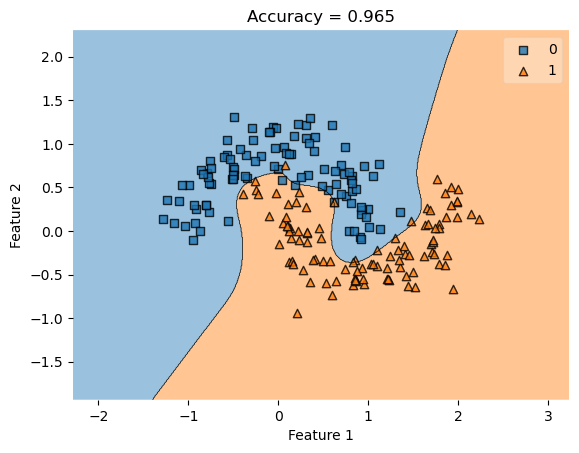

In [294]:
%reload_ext autoreload 
%autoreload 2

from kernel_logistic import KernelLogisticRegression 
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import make_moons, make_circles
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt 

X, y = make_moons(200, shuffle = True, noise = 0.2)
KLR = KernelLogisticRegression(rbf_kernel, gamma = 10)
KLR.fit(X, y)
KLR.score(X, y)

plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")


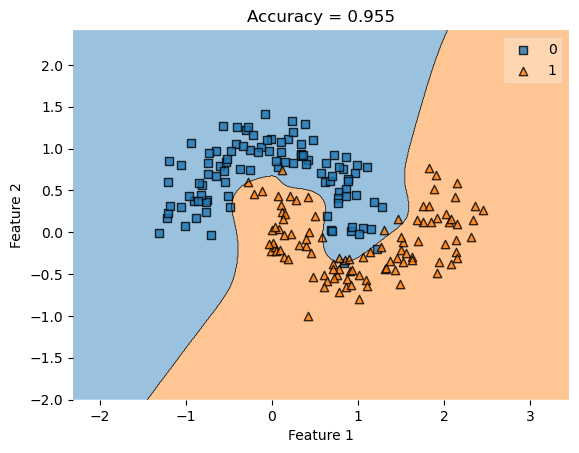

In [295]:
# new data with the same rough pattern
X, y = make_moons(200, shuffle = True, noise = 0.2)
plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")

However, as predicted before, a large gamma results in an overfitted model: 

1.0


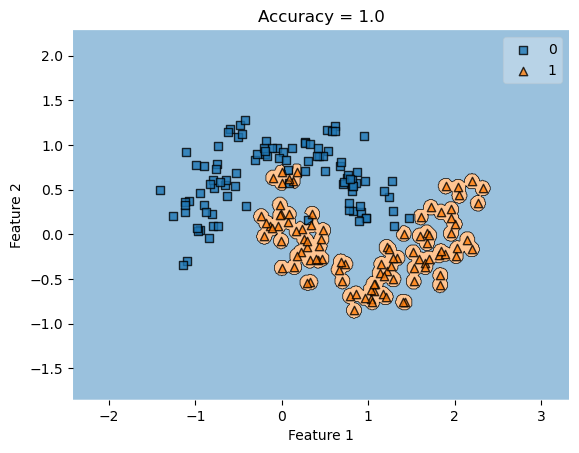

In [269]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt 

KLR = KernelLogisticRegression(rbf_kernel, gamma = 100000)
KLR.fit(X, y)
print(KLR.score(X, y))
plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")


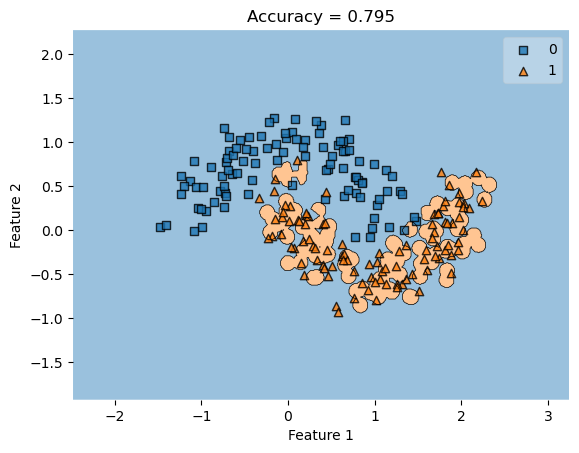

In [270]:
# new data with the same rough pattern
X, y = make_moons(200, shuffle = True, noise = 0.2)
plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")

# Experiment
Lets investigate which value of gamma is best for our model by plotting a graph of the training and validation score against different gamma values:

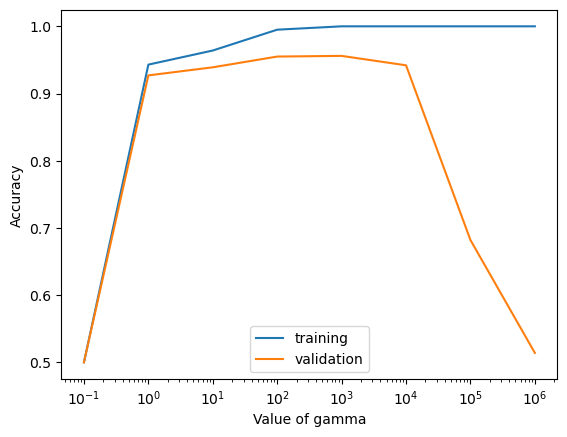

In [271]:
import pandas as pd
import numpy as np
np.random.seed()

def experiment(noise, data_geometry):
    gamma_values = 10.0**np.arange(-1, 7)
    df = pd.DataFrame({"gamma": [], "train" : [], "test" : []})

    for _ in range(10): #we perform 10 runs of the experiment and take the mean 
        X_train, y_train = data_geometry(100, shuffle = True, noise = noise)
        X_test, y_test = data_geometry(100, shuffle = True, noise = noise)

        for gamma in gamma_values:
            KLR = KernelLogisticRegression(rbf_kernel, gamma = gamma)
            KLR.fit(X_train, y_train)
            to_add = pd.DataFrame({"gamma" : [gamma],
                                "train" : [KLR.score(X_train, y_train)],
                                "test" : [KLR.score(X_test, y_test)]})

            df = pd.concat((df, to_add))


    means = df.groupby("gamma").mean().reset_index()

    plt.xscale("log")
    plt.plot(means["gamma"], means["train"], label = "training")
    plt.plot(means["gamma"], means["test"], label = "validation")
    plt.legend()
    labs = plt.gca().set(xlabel = "Value of gamma",
                ylabel = "Accuracy") 

experiment(0.2, make_moons)

From here, we find that a gamma of around 100 is best for this particular model. Now, what if we vary the noise of the data? Intuitively, a low noise should bring the training and validation scores "closer" since the pattern of the training data would not differ significantly from the testing data. On the other hand, higher noise should result in lower accuracy and it should take bigger values of gamma for the training score to converge. 

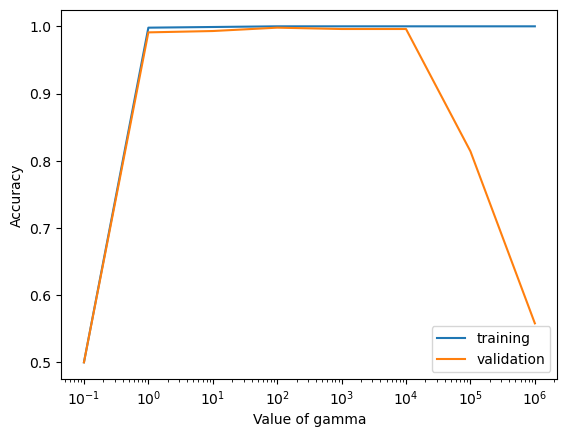

In [272]:
experiment(0.1, make_moons)

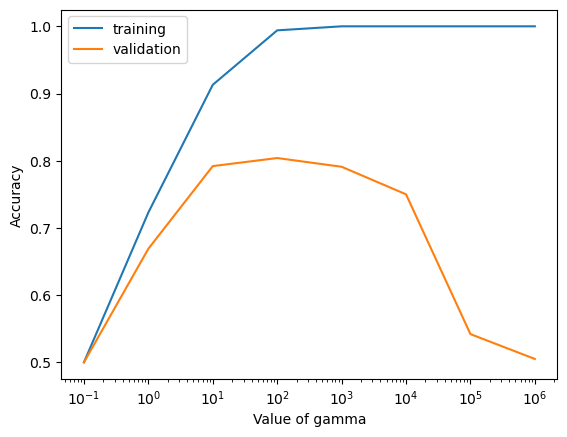

In [273]:
experiment(0.4, make_moons)

While the results fit our predictions, these graphs suggest that the value of gamma for each model is still around 100. In other words, gamma is independent from the noise! 

# A Different Data Pattern

Finally we try a different pattern to see the results. 

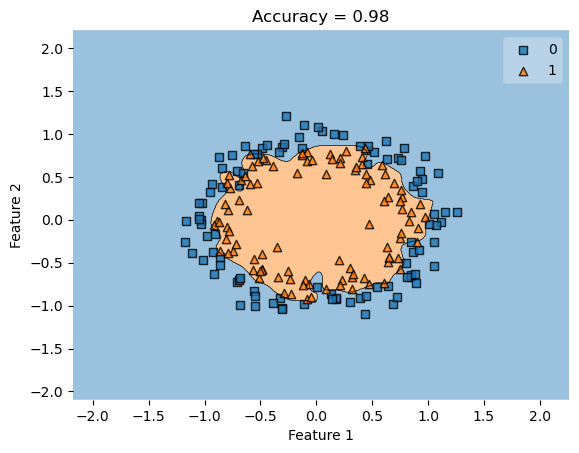

In [288]:
X, y = make_circles(200, shuffle = True, noise = 0.1)
KLR = KernelLogisticRegression(rbf_kernel, gamma = 100)
KLR.fit(X, y)
KLR.score(X, y)

plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")

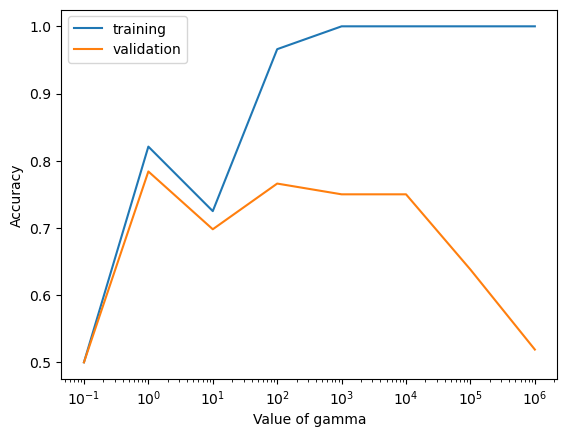

In [275]:
experiment(0.1, make_circles)

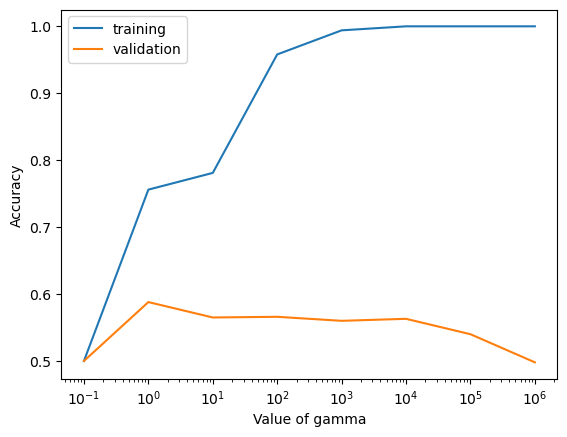

In [282]:
experiment(0.2, make_circles)

Here, we still find that the best gamma value is independent of the noise! However, such gamma value is 1 in this case, which differs from the previous pattern. 